## How much beer do my friends drink?

Imagine moving to a new city. You just settled in and made some new friends. You have been out for beers a couple times and now want to throw a housewarming party. Unfortunately you are a super poor student so you dont have too much money to just buy a lot of beer, but you still want to have a good time with your friends..  

So what do you do? How much beer should you buy?  

Because you are also a bit of a nerd you decide to make that decision using bayesian inference..

In [3]:
#Import some packages
import numpy as np
import pymc3 as pm
import arviz as az

%matplotlib inline

Because you also have a photographic memory (and are a bit weird) you remembered how much beer each of your friends had the last couple nights you have been out drinking

In [4]:
Peter = np.array([4, 5, 7, 10, 4])
Paul = np.array([8, 5, 10, 12, 9])
Mary = np.array([0, 3, 4, 6, 2])

## Ready for some bayesian inference?

Now you have your data so lets put it in a model and press the inference button. Essentially what we want to estimate is a probability distribution for the amount of beer each of your friends usually drinks on a night out.



# $ P(n_{beer}|D) = {P(D|n_{beer})P(n_{beer}) \over P(D)} $

In [32]:
def get_beer_posterior(data):

    #setting up a model using pythons context manager
    with pm.Model() as beer_model:
    
        #sets up a more or less flat uniform prior between 0 beers and 20 beers
        n_beer = pm.Uniform('n_beer', lower=0, upper=20)
        #n_beer = pm.TruncatedNormal('n_beer', mu=2, sigma=10, lower=0) #15
        
        #add a sigma term 
        sigma = pm.HalfCauchy('sigma', beta=1)
    
        #now combine priors and the data
        beer_observed = pm.Normal("beer_observed",
                                  mu=n_beer,
                                  sigma=sigma,
                                  observed=data)
    
    #all operations need to be performed in the context of our model
    with beer_model:
        #we now sample from the posterior using MCMC
        step = pm.NUTS(target_accept=0.95)
        trace = pm.sample(2000, tune=2000, return_inferencedata=True, step=step)
            
    return trace

In [25]:
trace_peter = get_beer_posterior(Peter)
trace_paul = get_beer_posterior(Paul)
trace_mary = get_beer_posterior(Mary)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, n_beer]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, n_beer]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, n_beer]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


Peter
Paul
Mary


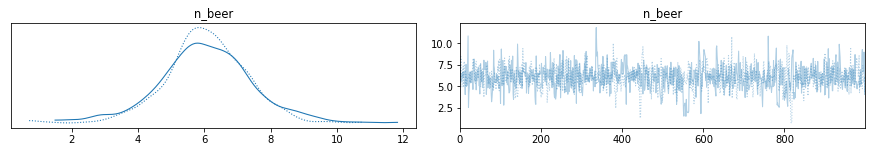

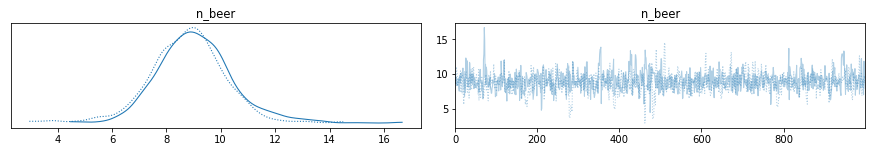

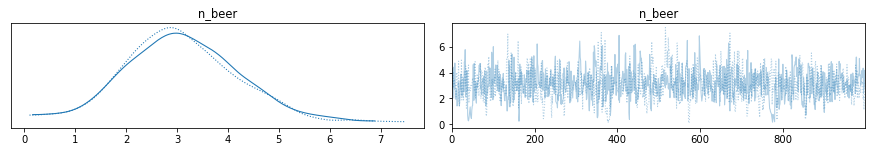

In [12]:
print('Peter')
az.plot_trace(trace_peter, var_names='n_beer')
print('Paul')
az.plot_trace(trace_paul, var_names='n_beer')
print('Mary')
az.plot_trace(trace_mary, var_names='n_beer');

In [28]:
az.summary(trace_peter)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n_beer,6.018,1.243,3.693,8.641,0.032,0.023,1559.0,991.0,1.0
sigma,2.752,1.146,1.204,4.695,0.036,0.026,1278.0,1306.0,1.0


In [29]:
az.summary(trace_paul)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n_beer,8.673,1.34,6.264,11.393,0.041,0.029,1248.0,835.0,1.0
sigma,2.825,1.17,1.297,4.939,0.033,0.024,1389.0,1665.0,1.0


In [30]:
az.summary(trace_mary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n_beer,3.039,1.126,0.889,5.131,0.034,0.024,998.0,844.0,1.0
sigma,2.463,1.049,1.100,4.274,0.028,0.020,1628.0,1577.0,1.0


So How do you now answer the question of how much beer you should buy?
Well, thats up to you. But if you want to be super sure that you dont end up buying not enough beer, why not take the upper bound of each credible intervall?

In [31]:
upper_bound = [az.summary(friend)['hdi_97%']['n_beer'] for friend in [trace_peter, trace_paul, trace_mary]]

np.sum(upper_bound)

#Probably you would also want to add yourself ;)

25.165

## So whos drinking the most?

Based on the posteriors of your parameter estimates you can now ask all sorts of questions e.g. whos going to drink the most and how certain can you be that this guess is going to be true?

In [19]:
import pandas as pd
import seaborn as sns

sns.set_style('ticks')
sns.set_context('talk')


get_posterior = lambda trace : np.array(trace.posterior['n_beer']).flatten()

In [20]:
#Probability that Peter drinks more than Mary
(get_posterior(trace_peter) > get_posterior(trace_mary)).mean()

0.9615

In [21]:
#Probability that Paul drinks more than Mary
(get_posterior(trace_paul) > get_posterior(trace_mary)).mean()

0.9925

In [22]:
#Probability that Paul drinks more than Peter
(get_posterior(trace_paul) > get_posterior(trace_peter)).mean()

0.9305

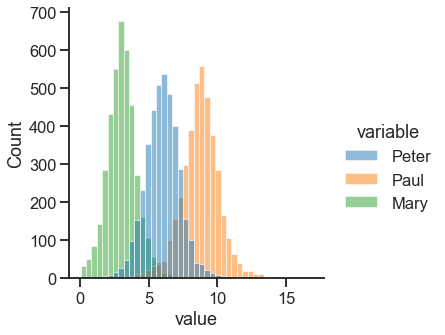

In [23]:
df_ppm = pd.DataFrame({'Peter': get_posterior(trace_peter),
                       'Paul': get_posterior(trace_paul),
                       'Mary': get_posterior(trace_mary)}).melt()

sns.displot(data=df_ppm, x='value', hue='variable');

In [29]:
Peter = np.array([4, 5, 7, 10, 4, 5, 4])
Paul = np.array([8, 5, 10, 12, 9, 5, 6])
Mary = np.array([1, 3, 4, 6, 2, 1, 0])